In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from datetime import datetime
import torch
import json
import mbuild as mb
import gmso
from gmso.external.convert_networkx import to_networkx
import networkx as nx
from urllib.request import urlopen
from urllib.parse import quote
import torch.nn.functional as F
import torch
from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GraphConv
from torch_geometric.nn import global_mean_pool
from torch.nn import Linear
from sklearn.metrics import mean_squared_error
from typing import List, Optional, Union
from collections.abc import Mapping, Sequence
from typing import List, Optional, Union

import torch.utils.data
from torch.utils.data.dataloader import default_collate

from torch_geometric.data import Batch, Dataset
from torch_geometric.data.data import BaseData

/Users/kieran/opt/miniconda3/envs/forward/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
COF_data_path = '/Users/kieran/iMoDELS-supplements/data/raw-data/everything.csv'
COF_data = pd.read_csv(COF_data_path, index_col=0)
COF_data = COF_data[['terminal_group_1','terminal_group_2','terminal_group_3', 'backbone', 'frac-1','frac-2','COF','intercept']]

molecules = glob.glob('/Users/kieran/terminal_groups_mixed/src/util/molecules/*.pdb')
molecules = list(set(molecules))
names2graph = {}
mol_smiles = {}
name2n_nodes = {}
name2xyz = {}
name2e_index = {}
name2mol = {}
name2x = {}
# name2edges

def replace_name_graph(chem_name):
    if chem_name == 'difluoromethyl' or chem_name == 'phenol' or chem_name == 'toluene':
        return
    else:
        return names2graph[chem_name]
def replace_n_nodes(chem_name):
    if chem_name == 'difluoromethyl' or chem_name == 'phenol' or chem_name == 'toluene':
        return
    else:
        return name2n_nodes[chem_name]
def replace_e_index(chem_name):
    if chem_name == 'difluoromethyl' or chem_name == 'phenol' or chem_name == 'toluene':
        return
    else:
        return name2e_index[chem_name]
def replace_node_att(chem_name):
    if chem_name == 'difluoromethyl' or chem_name == 'phenol' or chem_name == 'toluene':
        return
    else:
        x = torch.empty((len(elements),name2n_nodes[chem_name]), dtype=torch.int32)
        for i, p in enumerate(name2mol[chem_name].particles()):
            x[i] = element2vec[p]
        return x


def CIRconvert(ids):
    url = 'http://cactus.nci.nih.gov/chemical/structure/' + quote(ids) + '/smiles'
    ans = urlopen(url).read().decode('utf8')
    return ans

for ids in set(COF_data['terminal_group_1']):
    try:
        mol_smiles[ids] = CIRconvert(ids)
    except:
        pass
mol_smiles['nitrophenyl'] = 'CC1=CC=C(C=C1)[N+]([O-])=O'
mol_smiles['isopropyl'] = 'CC(C)O'
mol_smiles['perfluoromethyl'] = 'CC(F)(F)F'
mol_smiles['fluorophenyl'] = 'CC1=CC=C(F)C=C1'
mol_smiles['carboxyl'] = '*C(=O)O'
mol_smiles['amino'] = 'CN'


names = ''.join(smiles.upper() for smiles in mol_smiles.values())
elements = [n for n in set(names) if n.isalpha()]


vecs = F.one_hot(torch.arange(0, 5), num_classes=5)
element2vec = {e:v for e, v in zip(elements, vecs)}
vec2element = {v:e for e, v in zip(elements, vecs)}

for m in molecules:
    mol_name = m.split('/')[-1].split('.')[0]
    if 'ch3' in mol_name:
        mol_name = mol_name.split('-')[0]
    mol = mb.load(m)
    G = to_networkx(mol.to_gmso())
    adj = nx.adjacency_matrix(G)
    names2graph[mol_name] = adj
    name2n_nodes[mol_name] = len(list(G.nodes))
    name2xyz[mol_name] = mol.xyz
    name2mol[mol_name] = mol
    e_index = torch.empty((2,mol.n_bonds), dtype=torch.int64)
    parts = {p:i for i, p in enumerate(mol.particles())}
    for i, b in enumerate(mol.bonds()):
        e_index[0,i] = parts[b[0]]
        e_index[1,i] = parts[b[1]]
    name2e_index[mol_name] = e_index
    x = torch.empty((mol.n_particles,len(elements)), dtype=torch.float32)
    for i, p in enumerate(mol.particles()):
        x[i] = element2vec[p.element.symbol]
    name2x[mol_name] = x
    
COF_data = COF_data.dropna()
COF_data = COF_data[(COF_data['frac-1']==.5)]
COF_data.reset_index()

/Users/kieran/opt/miniconda3/envs/forward/lib/python3.8/site-packages/gmso/core/subtopology.py:70: UserWarning: Setting a parent is potentially dangerous. Consider using Topology.add_subtopology instead
  warnings.warn(
/Users/kieran/opt/miniconda3/envs/forward/lib/python3.8/site-packages/gmso/core/topology.py:664: UserWarning: Non-parametrized site detected <Atom O, label: None id: 140565528847264>
  warnings.warn("Non-parametrized site detected {}".format(site))
/Users/kieran/opt/miniconda3/envs/forward/lib/python3.8/site-packages/gmso/core/topology.py:664: UserWarning: Non-parametrized site detected <Atom H, label: None id: 140565528847216>
  warnings.warn("Non-parametrized site detected {}".format(site))
/Users/kieran/opt/miniconda3/envs/forward/lib/python3.8/site-packages/gmso/core/topology.py:664: UserWarning: Non-parametrized site detected <Atom H, label: None id: 140565528847888>
  warnings.warn("Non-parametrized site detected {}".format(site))
/Users/kieran/opt/miniconda3/envs

,index,terminal_group_1,terminal_group_2,terminal_group_3,backbone,frac-1,frac-2,COF,intercept
0,0,acetyl,acetyl,acetyl,alkylsilane,0.5,0.5,0.140174,1.292272
1,1,acetyl,acetyl,carboxyl,alkylsilane,0.5,0.5,0.144711,3.382495
2,2,acetyl,acetyl,fluorophenyl,alkylsilane,0.5,0.5,0.120846,1.448256
3,3,acetyl,acetyl,hydroxyl,alkylsilane,0.5,0.5,0.149766,2.171407
4,4,acetyl,acetyl,isopropyl,alkylsilane,0.5,0.5,0.131951,0.748749
...,...,...,...,...,...,...,...,...,...
3344,3344,pyrrole,toluene,perfluoromethyl,alkylsilane,0.5,0.5,0.147257,0.866245
3345,3345,pyrrole,toluene,phenol,alkylsilane,0.5,0.5,0.132568,2.740356
3346,3346,pyrrole,toluene,phenyl,alkylsilane,0.5,0.5,0.135855,1.317521
3347,3347,pyrrole,toluene,pyrrole,alkylsilane,0.5,0.5,0.137062,1.261030


In [3]:
class PairData(Data):
    def __init__(self, edge_index_s=None, x_s=None, edge_index_t=None, x_t=None, y=None):
        super().__init__()
        self.edge_index_s = edge_index_s
        self.x_s = x_s
        self.edge_index_t = edge_index_t
        self.x_t = x_t
        self.y = y
    def __inc__(self, key, value, *args, **kwargs):
        if key == 'edge_index_s':
            return self.x_s.size(0)
        if key == 'edge_index_t':
            return self.x_t.size(0)
        else:
            return super().__inc__(key, value, *args, **kwargs)

class TribologyDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return glob.glob('/Users/kieran/terminal_groups_mixed/src/util/molecules/*.pdb')

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        pass

    def process(self):
        # Read data into huge `Data` list.
        data_list = []
        
        for i, row in COF_data.iterrows():  # Iterate in batches over the training dataset.
            if row.terminal_group_1 == 'difluoromethyl' or row.terminal_group_1 == 'phenol' or row.terminal_group_1 == 'toluene' or \
                 row.terminal_group_2 == 'difluoromethyl' or row.terminal_group_2 == 'phenol' or row.terminal_group_2 == 'toluene':
                continue
            x_s = name2x[row.terminal_group_1]
            edge_index_s = name2e_index[row.terminal_group_1]
            x_t = name2x[row.terminal_group_2]
            edge_index_t = name2e_index[row.terminal_group_2]
            data = PairData(edge_index_s, x_s, edge_index_t, x_t, y = torch.tensor(row.COF))
            data_list.append(data)

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])


In [4]:
dataset = TribologyDataset(root='.')

dataset.shuffle()
train_dataset = dataset[:2000]
test_dataset = dataset[2000:]
train_loader = DataLoader(train_dataset, batch_size=64, follow_batch=['x_s', 'x_t'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, follow_batch=['x_s', 'x_t'], shuffle=False)

Processing...
Done!


In [11]:
n_elements = 5

class PairGNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(PairGNN, self).__init__()
        torch.manual_seed(12345)
        self.conv1_1 = GraphConv(n_elements, hidden_channels)
        self.conv1_2 = GraphConv(hidden_channels, hidden_channels)
        self.conv1_3 = GraphConv(hidden_channels, hidden_channels)

        self.conv2_1 = GraphConv(n_elements, hidden_channels)
        self.conv2_2 = GraphConv(hidden_channels, hidden_channels)
        self.conv2_3 = GraphConv(hidden_channels, hidden_channels)

        self.lin1 = Linear(2*hidden_channels, 2*hidden_channels)
        self.lin2 = Linear(2*hidden_channels, hidden_channels)
        self.lin_final = Linear(hidden_channels, 1)

    def forward(self, x_s, edge_index_s, x_t, edge_index_t, x_s_batch, x_t_batch):
        x_s = self.conv1_1(x_s, edge_index_s)
        x_s = x_s.relu()
        x_s = self.conv1_2(x_s, edge_index_s)
        x_s = x_s.relu()
        x_s = self.conv1_3(x_s, edge_index_s)
        x_s = global_mean_pool(x_s, x_s_batch)
        x_s = F.dropout(x_s, p=0.5, training=self.training)

        x_t = self.conv2_1(x_t, edge_index_t)
        x_t = x_t.relu()
        x_t = self.conv2_2(x_t, edge_index_t)
        x_t = x_t.relu()
        x_t = self.conv2_3(x_t, edge_index_t)
        x_t = global_mean_pool(x_t, x_t_batch)
        x_t = F.dropout(x_t, p=0.5, training=self.training)

        x = torch.cat((x_s, x_t), dim=1)
        x = self.lin1(x)
        x = x.relu()
        x = self.lin2(x)
        x = x.relu()
        x = self.lin_final(x)
        
        return x

In [26]:
n_epochs = 100
model = PairGNN(hidden_channels=128)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

def train():
    model.train()
    epoch_loss = 0
    for data in train_loader:  # Iterate in batches over the training dataset.
        out = model(x_s=data.x_s.float(), edge_index_s=data.edge_index_s, x_t=data.x_t.float(),
                    edge_index_t=data.edge_index_t, x_s_batch = data.x_s_batch, x_t_batch = data.x_t_batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        epoch_loss += loss
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
    return epoch_loss

def test(loader):
    model.eval()

    squared_error = []
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(x_s=data.x_s.float(), edge_index_s=data.edge_index_s, x_t=data.x_t.float(),
                    edge_index_t=data.edge_index_t, x_s_batch = data.x_s_batch, x_t_batch = data.x_t_batch)
        res = data.y - out
        
        squared_error.append(torch.pow(res, 2).sum())

    return sum(squared_error) / len(squared_error)

training_loss = []
testing_loss = []

for epoch in range(1, n_epochs):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    training_loss.append(train_acc.detach().numpy())
    testing_loss.append(test_acc.detach().numpy())
    print(f'Epoch: {epoch:03d}, Train MSE: {train_acc:.4f}, Test MSE: {test_acc:.4f}')

/Users/kieran/opt/miniconda3/envs/forward/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/kieran/opt/miniconda3/envs/forward/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 001, Train MSE: 1.9399, Test MSE: 4.5168
Epoch: 002, Train MSE: 1.2434, Test MSE: 4.8490
Epoch: 003, Train MSE: 1.1539, Test MSE: 4.7538
Epoch: 004, Train MSE: 1.5170, Test MSE: 5.2531
Epoch: 005, Train MSE: 1.5871, Test MSE: 5.3106
Epoch: 006, Train MSE: 1.0313, Test MSE: 3.7780
Epoch: 007, Train MSE: 0.9936, Test MSE: 4.0974
Epoch: 008, Train MSE: 1.4585, Test MSE: 4.6294
Epoch: 009, Train MSE: 1.1938, Test MSE: 3.9663
Epoch: 010, Train MSE: 1.0246, Test MSE: 3.5477
Epoch: 011, Train MSE: 0.8579, Test MSE: 2.9595
Epoch: 012, Train MSE: 0.8693, Test MSE: 2.6871
Epoch: 013, Train MSE: 0.9094, Test MSE: 1.9636
Epoch: 014, Train MSE: 0.8201, Test MSE: 1.9024
Epoch: 015, Train MSE: 0.7964, Test MSE: 1.6647
Epoch: 016, Train MSE: 1.0586, Test MSE: 2.0867
Epoch: 017, Train MSE: 0.7911, Test MSE: 1.5282
Epoch: 018, Train MSE: 1.0394, Test MSE: 1.8413
Epoch: 019, Train MSE: 0.8676, Test MSE: 1.5352
Epoch: 020, Train MSE: 1.1689, Test MSE: 1.8412
Epoch: 021, Train MSE: 1.3266, Test MSE:

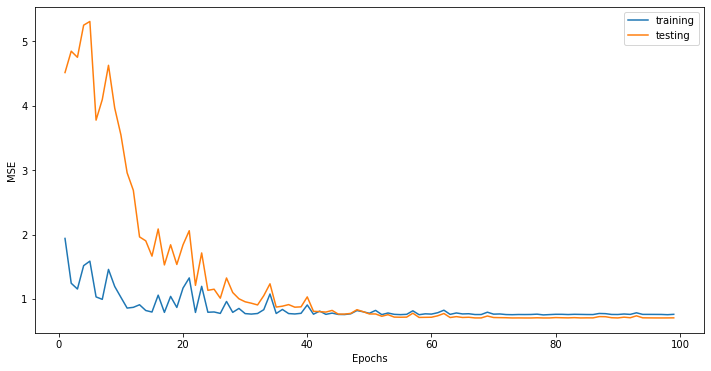

In [29]:
plt.figure(figsize=(12,6))
plt.plot(range(1, n_epochs), training_loss,label='training')
plt.plot(range(1, n_epochs), testing_loss,label='testing')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend()